c:\Users\rehan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


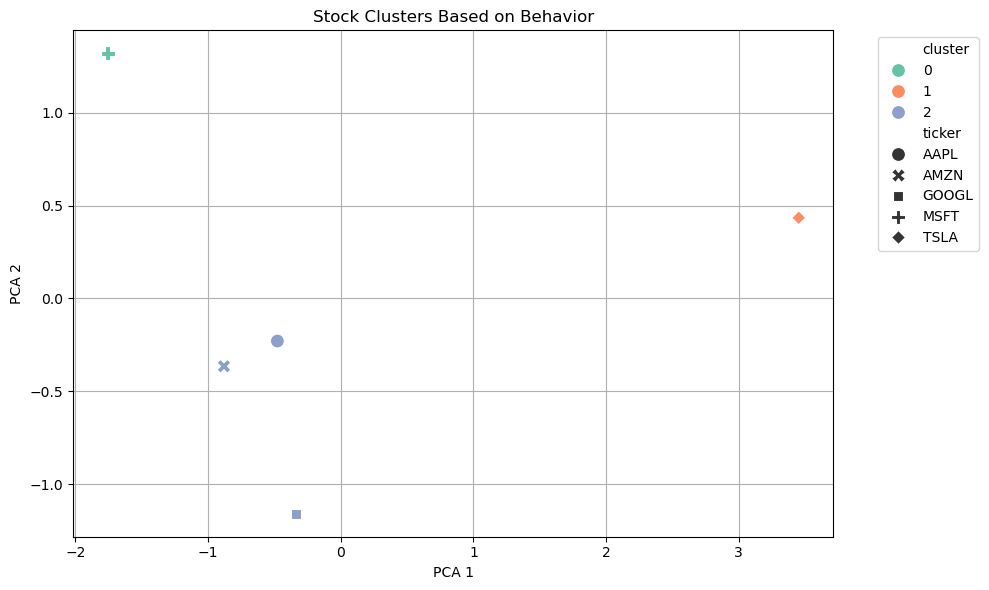

Index(['date', 'daily_return', 'volatility_7', 'volatility_30', 'cum_return',
       'ticker', 'pca1', 'pca2', 'cluster'],
      dtype='object')
         date  daily_return  volatility_7  volatility_30   cum_return ticker  \
0  2025-07-10      0.001137      0.012052       0.010937  2122.189013   AAPL   
1  2025-07-10     -0.011234      0.012614       0.013551  2543.815029   AMZN   
2  2025-07-10     -0.008380      0.012508       0.015650    70.071656  GOOGL   
3  2025-07-10     -0.007060      0.010141       0.007350  7242.785536   MSFT   
4  2025-07-10      0.025232      0.041917       0.042273   267.658837   TSLA   

       pca1      pca2  cluster  
0 -0.477816 -0.229351        2  
1 -0.880627 -0.365230        2  
2 -0.335787 -1.159104        2  
3 -1.757898  1.319452        0  
4  3.452128  0.434234        1  


In [ ]:
# 📊 Clustering Stock Behaviors
# Author: Rehan Chaudhry

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pathlib import Path

# -------------------------------
# 📁 Load all processed files
# -------------------------------
processed_dir = Path("../data/processed")
dfs = []

for file in processed_dir.glob("*_features.csv"):
    df = pd.read_csv(file)
    ticker = file.stem.split("_")[0]
    df = df[['date', 'daily_return', 'volatility_7', 'volatility_30', 'cum_return']]
    df['ticker'] = ticker
    dfs.append(df)

# Merge into one DataFrame (latest date per ticker)
latest_data = pd.concat([df.sort_values('date').iloc[-1:] for df in dfs], ignore_index=True)

# -------------------------------
# 🧼 Preprocessing
# -------------------------------
features = ['daily_return', 'volatility_7', 'volatility_30', 'cum_return']
X = latest_data[features].copy()

# Handle missing values if any
X = X.dropna()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# 🧠 PCA
# -------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA result back to DataFrame
latest_data['pca1'] = X_pca[:, 0]
latest_data['pca2'] = X_pca[:, 1]

# -------------------------------
# 🎯 Clustering (KMeans)
# -------------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
latest_data['cluster'] = kmeans.fit_predict(X_scaled)

# -------------------------------
# 📊 Visualization
# -------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(data=latest_data, x='pca1', y='pca2', hue='cluster', style='ticker', palette='Set2', s=100)
plt.title("Stock Clusters Based on Behavior")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()




## 🔍 Interpreting PCA Results

We reduced 4 input features:
- `daily_return`
- `volatility_7`
- `volatility_30`
- `cum_return`

...into two principal components using **PCA**:

- **`pca1`**: Captures **volatility-driven behavior** (higher = more volatile)
- **`pca2`**: Captures **return performance** (higher = stronger long-term performance)

### 💡 Example Interpretations:
| Ticker | pca1 | pca2 | Interpretation |
|--------|------|------|----------------|
| TSLA   | +3.45 | +0.43 | 🚨 High volatility, moderate return |
| MSFT   | -1.76 | +1.31 | ✅ Low volatility, strong return |
| GOOGL  | -0.34 | -1.16 | ⚠️ Weak return, low volatility |
| AMZN   | -0.88 | -0.36 | Average performer |
| AAPL   | -0.47 | -0.23 | Similar to AMZN |

PCA allows us to:
- 🧠 Group similar stock behaviors via clustering
- 🔭 Visualize complex financial patterns in 2D
- 🚨 Detect outlier behavior like TSLA's



In [2]:
latest_data[['ticker', 'pca1', 'pca2', 'cluster']].sort_values('cluster')


,ticker,pca1,pca2,cluster
3,MSFT,-1.757898,1.319452,0
4,TSLA,3.452128,0.434234,1
0,AAPL,-0.477816,-0.229351,2
1,AMZN,-0.880627,-0.365230,2
2,GOOGL,-0.335787,-1.159104,2


In [3]:
latest_data.groupby('cluster')[['daily_return', 'volatility_7', 'volatility_30', 'cum_return']].mean()


,daily_return,volatility_7,volatility_30,cum_return
cluster,,,,
0,-0.007060,0.010141,0.007350,7242.785536
1,0.025232,0.041917,0.042273,267.658837
2,-0.006159,0.012391,0.013379,1578.691899


## 📊 Cluster Behavior Summary

Each cluster shows distinct behavior in terms of return and volatility:

| Cluster | Mean Daily Return | Volatility (7d) | Volatility (30d) | Cumulative Return |
|---------|-------------------|------------------|-------------------|-------------------|
| **0**   | -0.0071            | 0.0101           | 0.0074            | 7,243             |
| **1**   |  0.0252            | 0.0419           | 0.0423            | 268               |
| **2**   | -0.0062            | 0.0124           | 0.0134            | 1,579             |

### 🔍 Interpretation

- **Cluster 0**: 🟢 **Low-volatility, high return** — steady long-term growth (e.g. MSFT)
- **Cluster 1**: 🔴 **High-volatility, recent winner** — speculative behavior (e.g. TSLA)
- **Cluster 2**: 🔵 **Moderate on all metrics** — typical tech stock behavior (e.g. AAPL, AMZN, GOOGL)

These profiles help investors or analysts prioritize which clusters to monitor for breakout opportunities or risk management.


In [5]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Select the same features you used for PCA
X = latest_data[["daily_return", "volatility_7", "volatility_30", "cum_return"]]
X_scaled = StandardScaler().fit_transform(X)

# Run DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=2)
latest_data["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

print(latest_data['dbscan_cluster'].value_counts())

# -------------------------------
# 💾 Save the clustered data
# -------------------------------


latest_data.to_csv("../data/processed/clustered_latest_data.csv", index=False)


dbscan_cluster
 0    3
-1    2
Name: count, dtype: int64


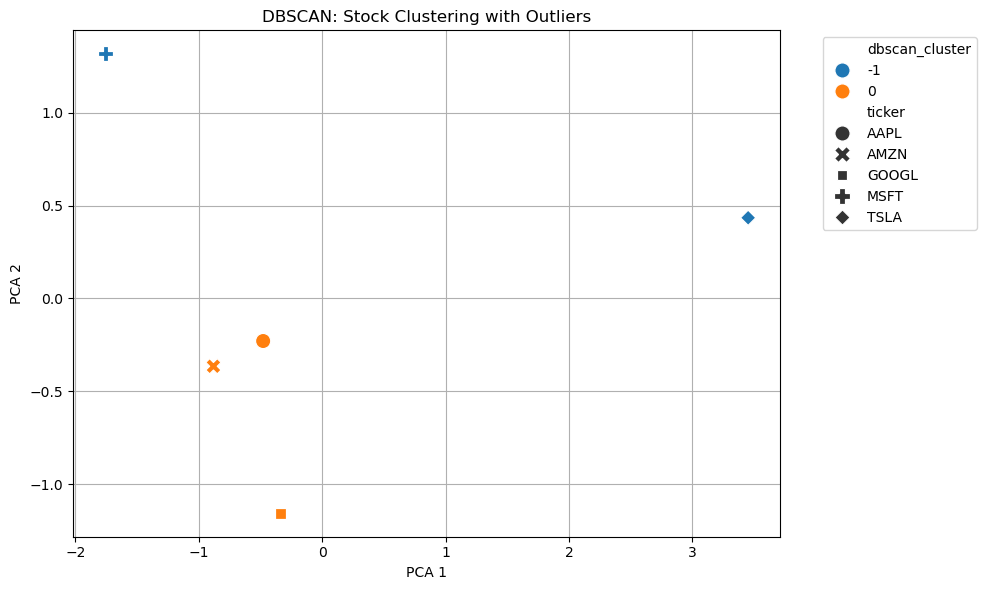

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=latest_data,
    x='pca1',
    y='pca2',
    hue='dbscan_cluster',
    style='ticker',
    palette='tab10',
    s=120
)
plt.title("DBSCAN: Stock Clustering with Outliers")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
